<a href="https://colab.research.google.com/github/mustafabozkaya/DeepLearningBootcamp2022/blob/master/Bootcamp_Solution/classify_mnist_audio_using_spectrograms_keras_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](https://i.imgur.com/OX1ADxu.png)

# Introduction

With the advances in deep learning and neural networks, it is now possible to create simple yet powerful networks able to perform classification, forecasting and object detection tasks that were previously highly complex and sometimes even infeasible. In deep learning, a convolutional neural network (CNN, or ConvNet) is a class of deep neural networks, most commonly applied to analyzing visual imagery. They're very powerful at recognizing and classifiying objects and patterns in images when presented with suitable data and a very specific task. However, it turns out at these CNN's are not limited to problems originiating in computer vision, but can also be applied to non-image problems. For instance, a sound can be converted to a spectogram, which is a chart that shows the amount of each frequency at each time in an audio file. It has  been shown that this approach can beat state-of-the-art environmental sound detection models. In this notebook, we'll use CNN's to classify spoken words from the Audio MNIST dataset. The dataset contains 3000 audio files, where a human pronounces one of ten digits (0-9).

Key takeaways from this notebook:

* We convert 3000 MNIST audio files to spectograms.
* We use Tensorflow's API to create a CNN with multiple 2D convolution layers.
* The network prove excellent at classifying the spectograms in 10 distinct classes. 
* Final validation accuracy is about 95%.

First load the data, then print example files and then plot WAV files.

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import wave # for reading audio files in .wav format
import pylab # for plotting waveforms and spectrograms
from pathlib import Path
from scipy import signal
from scipy.io import wavfile # wavfile reads wav files and returns the sample rate (in samples/sec) and data as numpy array
from sklearn.metrics import confusion_matrix # for confusion matrix plot 
import itertools # itertools is used for efficient looping 


In [34]:
%cd ../content

/content


In [35]:

!mkdir outputs


mkdir: cannot create directory ‘outputs’: File exists


In [36]:
!git clone https://github.com/DS-ML-DL-AI-Solutions/free-spoken-digit-dataset.git  digit_datasets/

fatal: destination path 'digit_datasets' already exists and is not an empty directory.


In [ ]:
# Set paths to input and output data
INPUT_DIR = 'digit_datasets/free-spoken-digits/free-spoken-digit-dataset-master/'
OUTPUT_DIR = 'outputs/'

# Print names of 10 WAV files from the input path
parent_list = os.listdir(INPUT_DIR)
for i in parent_list:
    print(i)

In [ ]:
# Print names of 10 WAV files from the input path
recordings=os.listdir(INPUT_DIR+parent_list[5])
for i in range(10):
    print(recordings[i])

In [ ]:
# display pip requirements file
INPUT_DIR+parent_list[4]

'/kaggle/input/free-spoken-digits/free-spoken-digit-dataset-master/pip_requirements.txt'

In [ ]:
%cat '/kaggle/input/free-spoken-digits/free-spoken-digit-dataset-master/pip_requirements.txt'

cycler==0.10.0
matplotlib==1.5.1
numpy==1.11.0
pyparsing==2.1.5
python-dateutil==2.5.3
pytz==2016.4
scipy==0.17.1
six==1.10.0
wheel==0.24.0


In [ ]:
with open(INPUT_DIR+parent_list[4], encoding="utf-8") as f:
    pkgs = f.read()
    print(pkgs)

cycler==0.10.0
matplotlib==1.5.1
numpy==1.11.0
pyparsing==2.1.5
python-dateutil==2.5.3
pytz==2016.4
scipy==0.17.1
six==1.10.0
wheel==0.24.0



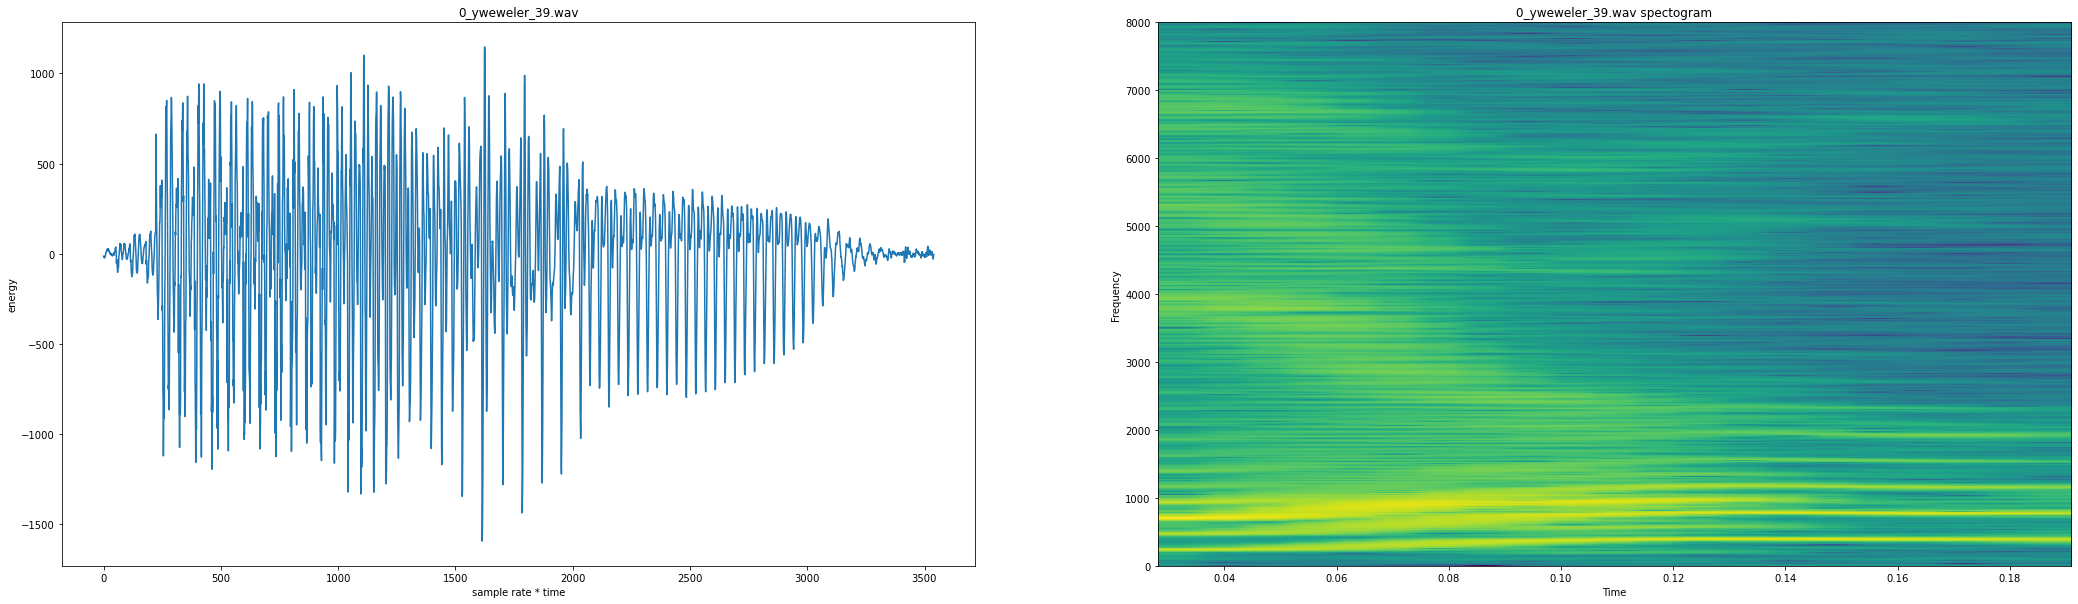

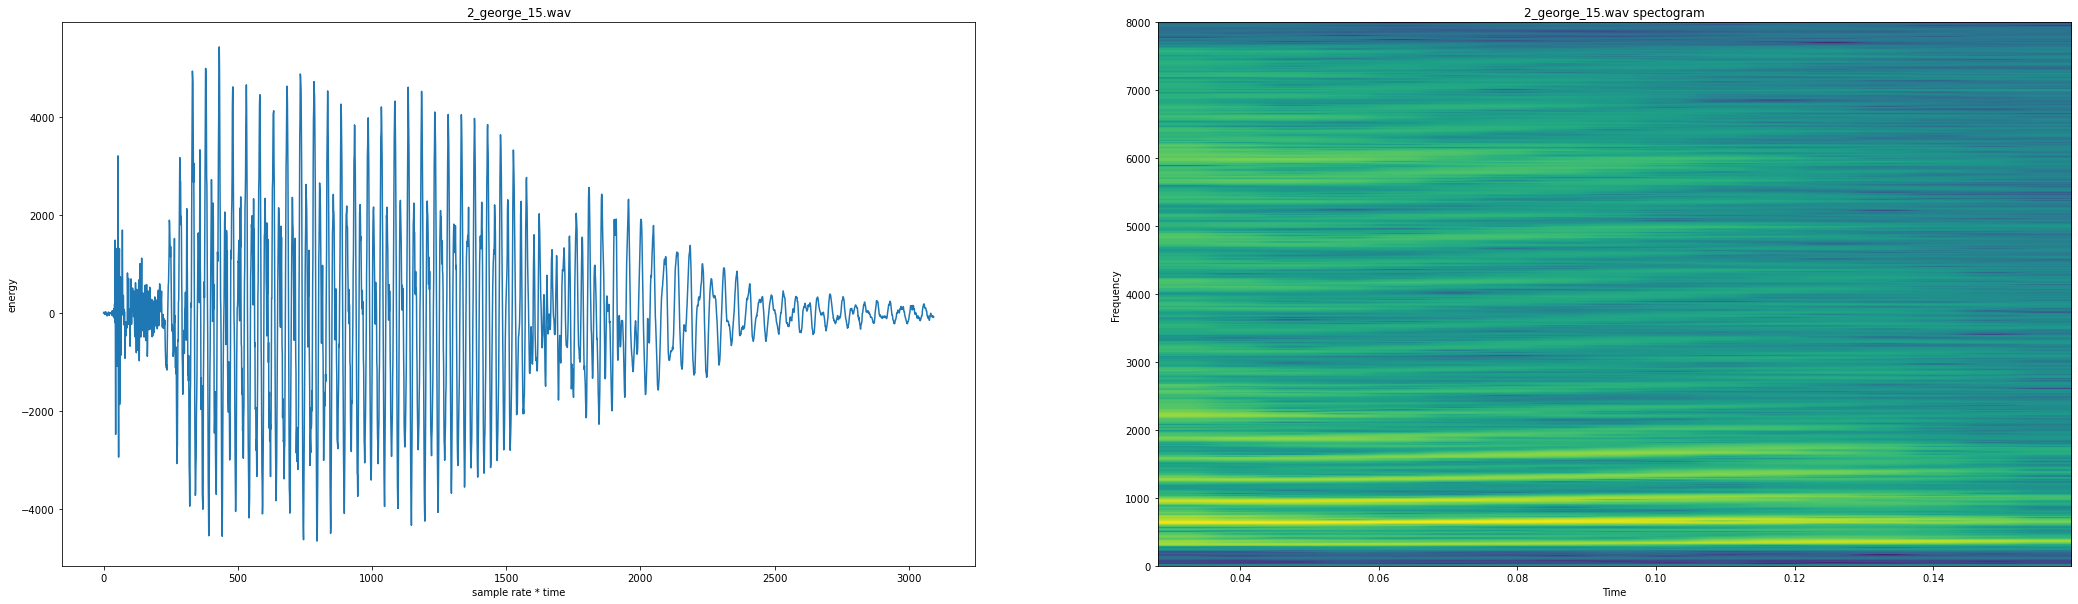

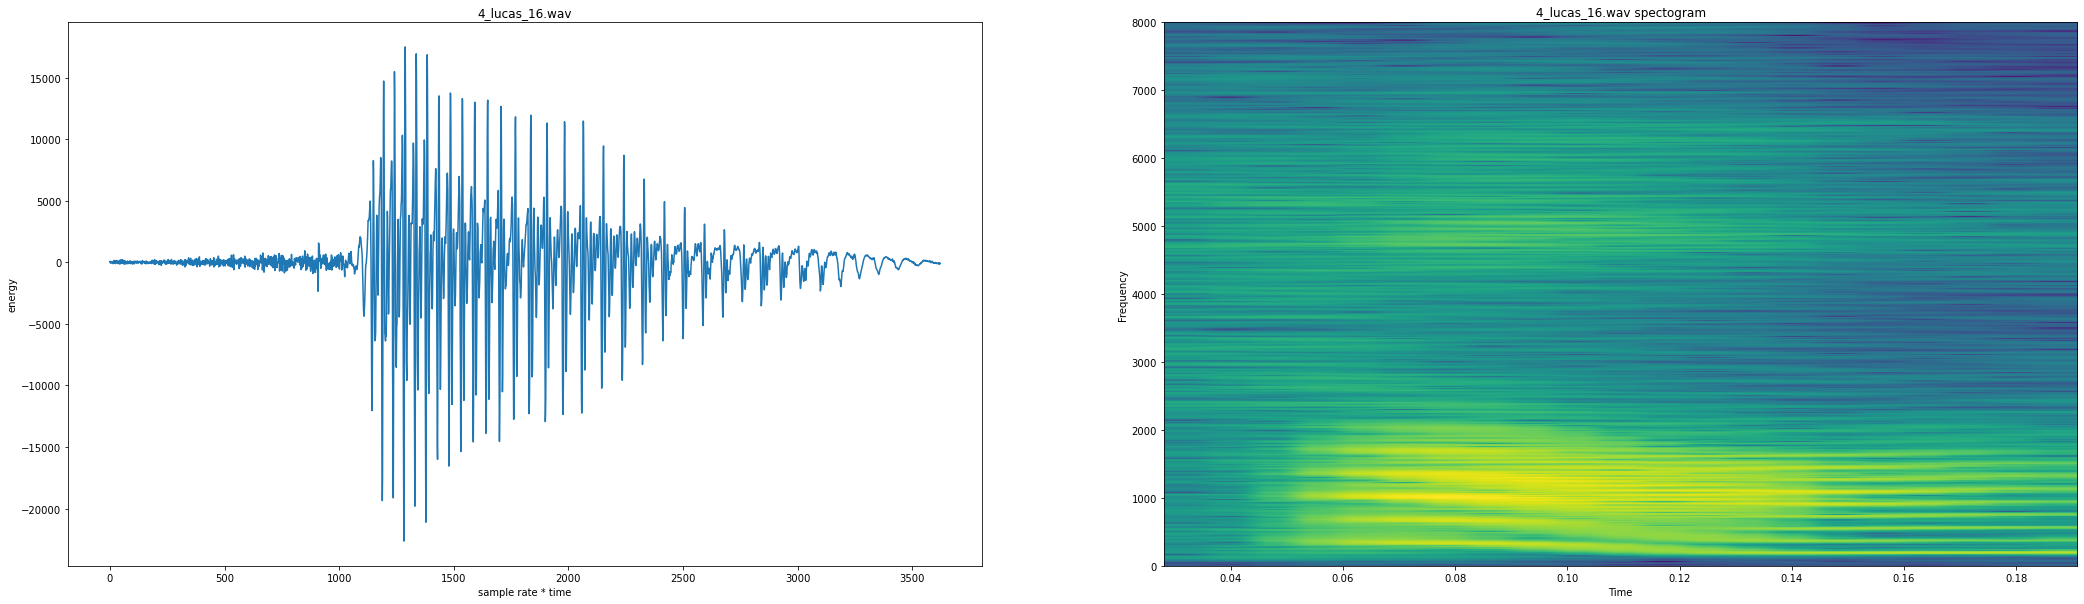

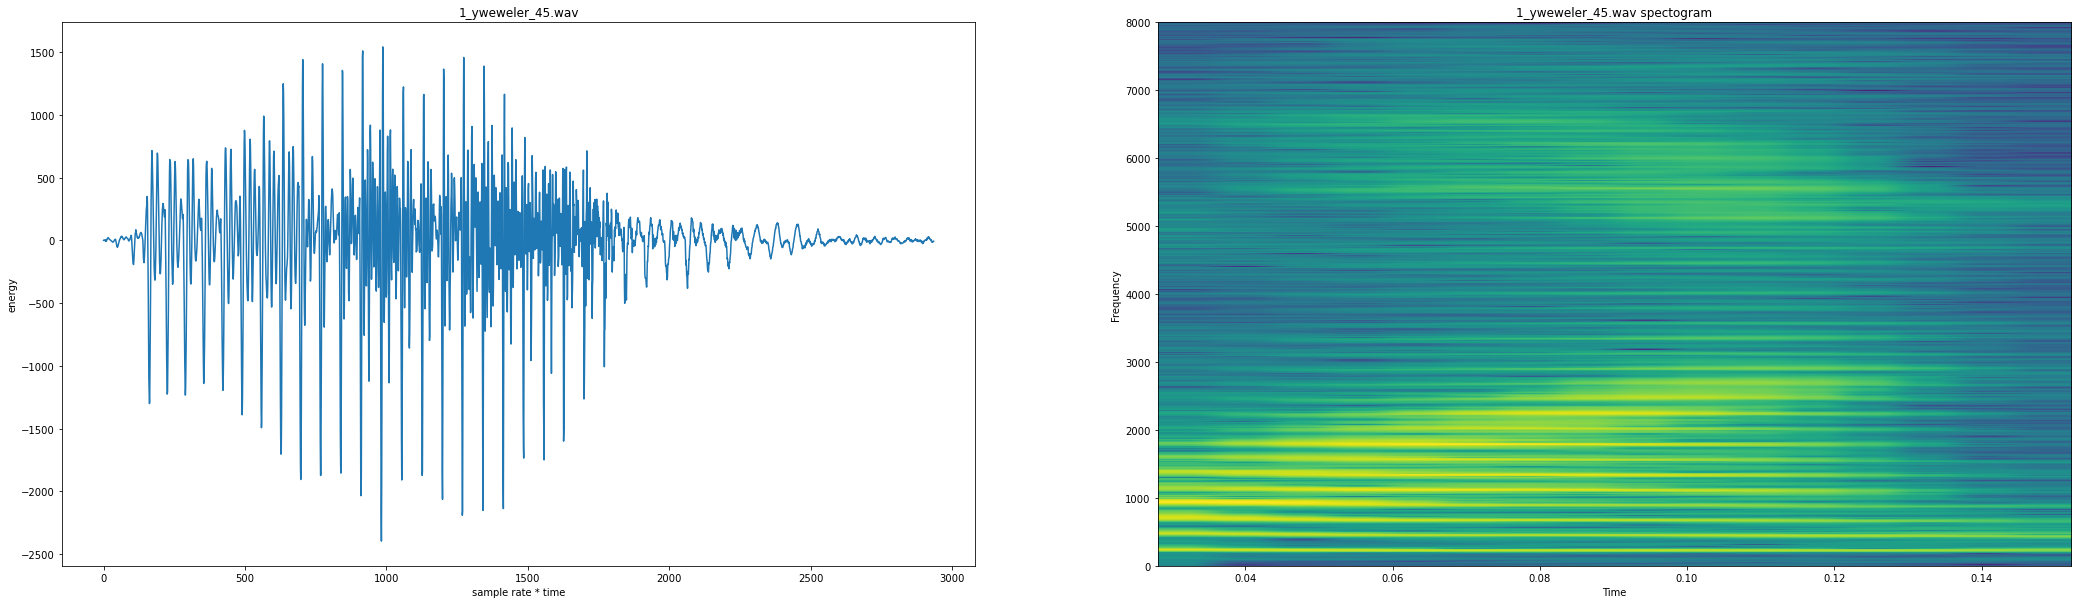

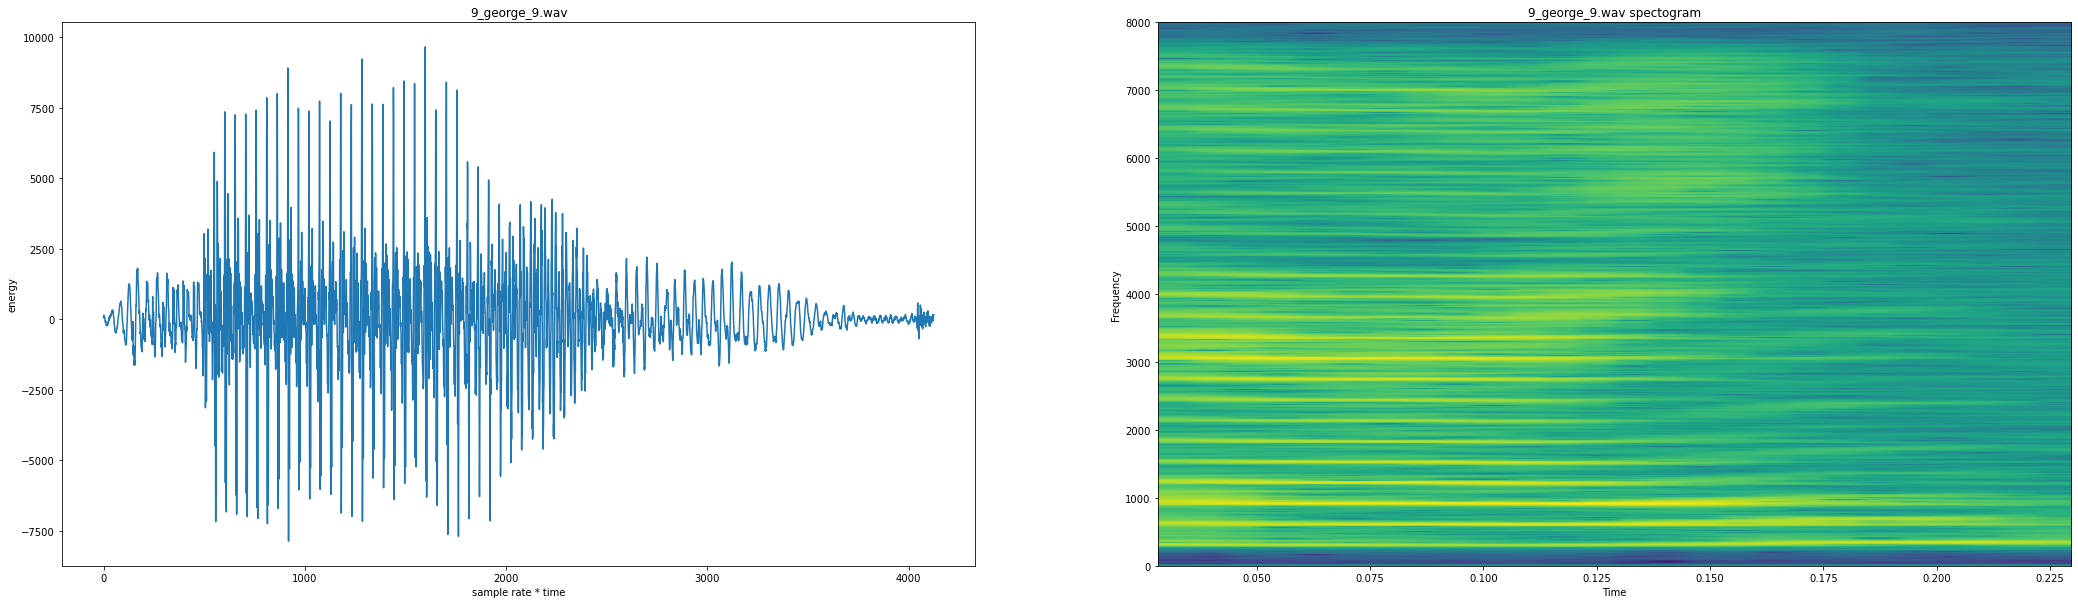

In [ ]:
# Plot first 5 WAV files as a waveform and a frequency spectrum
for i in range(5): 
    signal_wave = wave.open(os.path.join(INPUT_DIR+parent_list[5], recordings[i]), 'r')
    sample_rate = 16000
    sig = np.frombuffer(signal_wave.readframes(sample_rate), dtype=np.int16)

    plt.figure(figsize=(36,10))
    plot_a = plt.subplot(121)
    plot_a.set_title(recordings[i])
    plot_a.plot(sig)
    plot_a.set_xlabel('sample rate * time')
    plot_a.set_ylabel('energy')

    plot_b = plt.subplot(122)
    plot_b.set_title(recordings[i]+" spectogram")
    plot_b.specgram(sig, NFFT=1024, Fs=sample_rate, noverlap=900)
    plot_b.set_xlabel('Time')
    plot_b.set_ylabel('Frequency')

plt.show()

You can clearly see the difference in the energy distribution when different words are being pronounced. These distinct characteristics also show up in the spectograms of the recordings, which will enable us transform what was originally an audio problem to an image problem.

# Convert audio files to spectograms

We can now do the actual conversion of every audio sample. The code below uses the wave and pylab library to extract sound information and frame rate from each sample and save the result as a spectrogram. After this we've simply converted our audio problem to a image problem.

In [ ]:
input_path=INPUT_DIR+parent_list[5]
input_path

'/kaggle/input/free-spoken-digits/free-spoken-digit-dataset-master/recordings'

In [ ]:
# Utility function to get sound and frame rate info
def get_wav_info(wav_file):
    wav = wave.open(wav_file, 'r') # open the file,retrieve the metadata and the sound data from the file
    frames = wav.readframes(-1) # read all frames from the file ,frames is a string of bytes
    sound_info = pylab.frombuffer(frames, 'int16') # convert the string of bytes to a numpy array
    frame_rate = wav.getframerate() # get the frame rate ,frame_rate is an integer and is the number of frames per second
    wav.close() # close the file
    return sound_info, frame_rate 

# For every recording, make a spectogram and save it as label_speaker_no.png
if not os.path.exists(os.path.join(OUTPUT_DIR, 'sounds-images')):
    os.mkdir(os.path.join(OUTPUT_DIR, 'sounds-images'))  # create a folder to save the spectograms
    
for filename in os.listdir(input_path): # loop through all the files and folders
    #print(filename)
    if "wav" in filename: # check whether the file is in .wav format
        file_path = os.path.join(input_path, filename) # generate the full path to the file
        file_stem = Path(file_path).stem # get the file name,stems are the part of the file name before the first dot
        #print(file_stem)
        target_dir = f'class_{file_stem[0]}' # get the label from the file name
        dist_dir = os.path.join(os.path.join( OUTPUT_DIR, 'sounds-images'), target_dir) # generate the full path to the folder to save the spectogram
        file_dist_path = os.path.join(dist_dir, file_stem) # generate the full path to the file to save the spectogram
        if not os.path.exists(file_dist_path + '.png'): # check whether the file already exists
            if not os.path.exists(dist_dir): # check whether the folder already exists
                os.mkdir(dist_dir)
            file_stem = Path(file_path).stem # get the file name
            sound_info, frame_rate = get_wav_info(file_path) # get sound and frame rate info
            pylab.specgram(sound_info, Fs=frame_rate) # make a spectogram and save it as label_speaker_no.png (e.g. 0_jackson_0.png)
            pylab.savefig(f'{file_dist_path}.png') # save the spectogram to the folder with the label as the name
            pylab.close() # close the file

# Print the ten classes in our dataset
path_list = os.listdir(os.path.join(OUTPUT_DIR, 'sounds-images'))
print("Classes: \n")
for i in range(10):
     print(path_list[i]) # print the first 10 classes
    
# File names for class 1
path_list = os.listdir(os.path.join(OUTPUT_DIR, 'sounds-images/class_1'))
print("\nA few example files: \n")
for i in range(10):
        print(path_list[i]) # print the first 10 files

Classes: 

class_6
class_2
class_9
class_4
class_0
class_1
class_8
class_7
class_3
class_5

A few example files: 

1_yweweler_20.png
1_nicolas_0.png
1_jackson_43.png
1_jackson_19.png
1_jackson_29.png
1_nicolas_30.png
1_nicolas_13.png
1_george_12.png
1_jackson_15.png
1_yweweler_9.png


# Preparing the data

We can now load the spectrograms into memory. We use the image_dataset_from_directory utility to generate the datasets, and we use Keras image preprocessing layers for image standardization and data augmentation. The validation set is what will ultimately be our benchmark when becomes to performance and accuracy of our classifier. The batch size is set fairly low for now (32) for all images to fit in memory. The seed is for reproducibility.

More information: https://keras.io/examples/vision/image_classification_from_scratch/

In [ ]:
# Declare constants
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
BATCH_SIZE = 32
N_CHANNELS = 3
N_CLASSES = 10

# Make a dataset containing the training spectrograms
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
                                             batch_size=BATCH_SIZE,
                                             validation_split=0.2,
                                             directory=os.path.join(OUTPUT_DIR, 'sounds-images'),
                                             shuffle=True,
                                             color_mode='rgb',
                                             image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                             subset="training",
                                             seed=0)

# Make a dataset containing the validation spectrogram
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
                                             batch_size=BATCH_SIZE,
                                             validation_split=0.2,
                                             directory=os.path.join(OUTPUT_DIR, 'sounds-images'),
                                             shuffle=True,
                                             color_mode='rgb',
                                             image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                             subset="validation",
                                             seed=0)

Found 3000 files belonging to 10 classes.
Using 2400 files for training.
Found 3000 files belonging to 10 classes.
Using 600 files for validation.


In [ ]:
# print how many image bachs  are in the training and validation datasets
print("Number of training image bachs: ", len(train_ds))
print("Number of validation image bachs: ", len(valid_ds))

Number of training image bachs:  75
Number of validation image bachs:  19


In [ ]:
# split valid dataset to test and valid
test_ds = valid_ds.take(8) # get 100 data from valid dataset
valid_ds = valid_ds.skip(8) # skip first 100

In [ ]:
# how many bachs are in the training ,test and validation datasets
print("Number of training batches: ", len(train_ds))
print("Number of validation batches: ", len(valid_ds))
print("Number of test  batches: ", len(test_ds))

Number of training batches:  75
Number of validation batches:  11
Number of test  batches:  8


Let's quickly visualize a few of the generated spectograms and their labels.

In [ ]:
#Checking images and labels shapes (amount of images, height, width, color channels)
for ds in [train_ds,valid_ds,test_ds]:
    for image_batch, labels_batch in ds:
      print(f" image shape :{ image_batch.shape}")
      print(f" label shape :{labels_batch.shape}")
      break

 image shape :(32, 256, 256, 3)
 label shape :(32,)
 image shape :(32, 256, 256, 3)
 label shape :(32,)
 image shape :(32, 256, 256, 3)
 label shape :(32,)


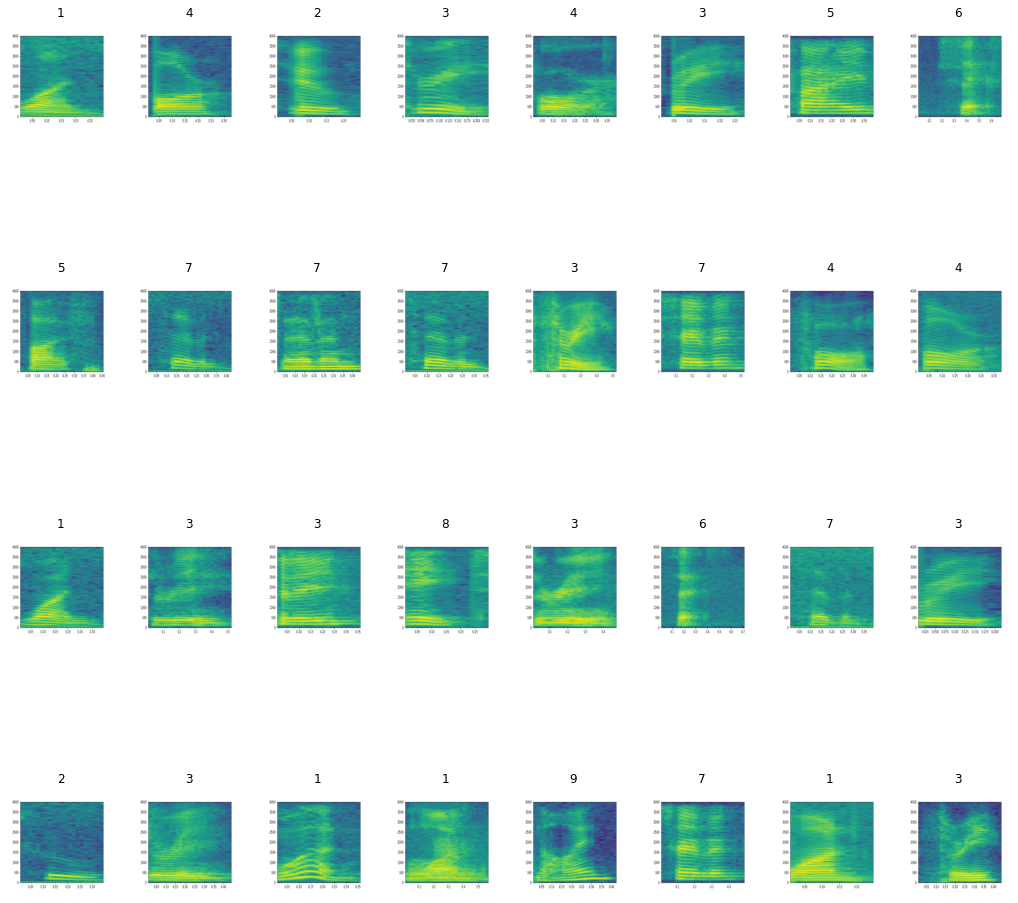

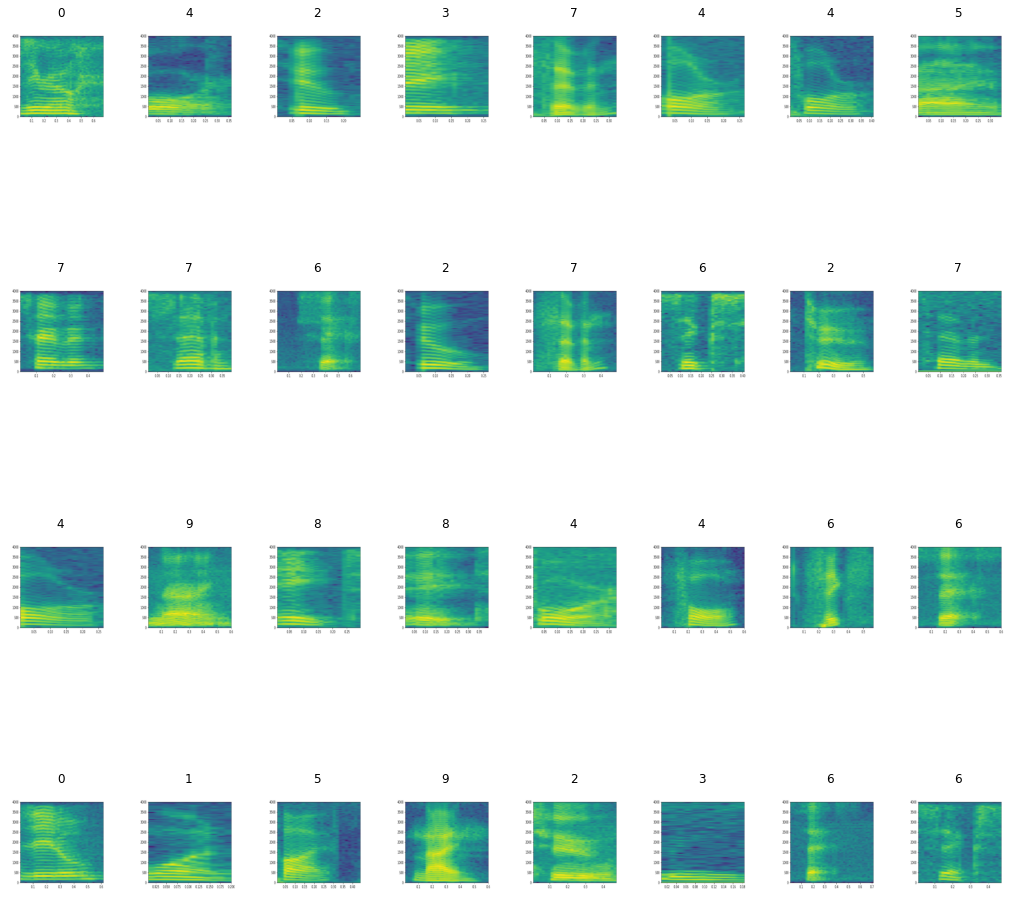

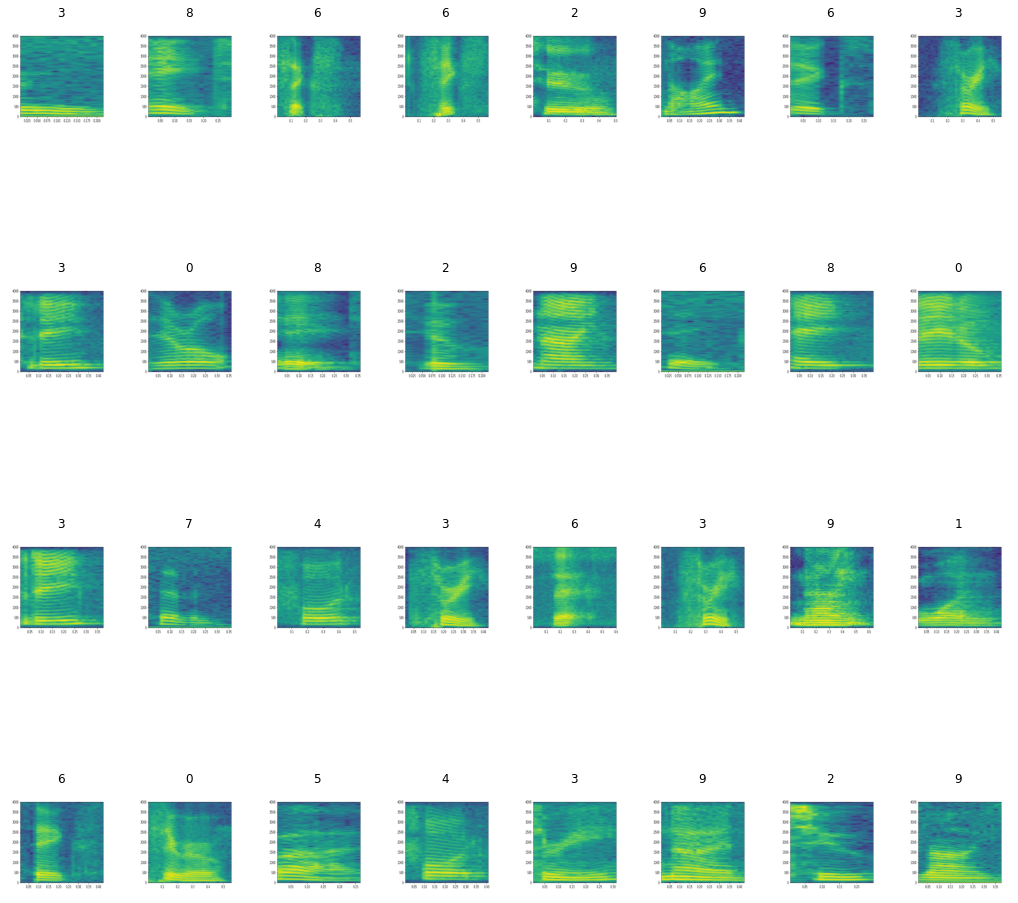

In [ ]:
#Displaying image samples 
for ds in [train_ds,valid_ds,test_ds]:
    plt.figure(figsize=(18, 18))
    plt.title("=========================")
    
    for images, labels in train_ds.take(1):
        for i in range(32):
            ax = plt.subplot(4,8,i+1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(int(labels[i]))
            plt.axis("off")
plt.show()

Before we can build our model and start training, we need to apply one simple augmentation the dataset and that is rescaling. We rescale an input in the (0, 255) range to be in the (0,1) range.

In [ ]:
# Function to prepare our datasets for modelling
def prepare(ds, augment=False):
    # Define our one transformation
    rescale = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.Rescaling(1./255)])
    flip_and_rotate = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
    ])
    
    # rescale the data to the range [0,1] and apply it to both the training and validation datasets ,training=True means that the layer will only be applied to the training data
    ds = ds.map(lambda x, y: (rescale(x, training=True), y)) 
    if augment: 
        ds = ds.map(lambda x, y: (flip_and_rotate(x, training=True), y)) # apply the transformation to the training data
    return ds

train_ds = prepare(train_ds, augment=False)
valid_ds = prepare(valid_ds, augment=False)
test_ds = prepare(test_ds, augment=False)

# Modelling

![](https://cdn-images-1.medium.com/max/1000/1*ytBUCmhkAucJ5imsNfAyfQ.png)

Keras is one of the most popular deep learning libraries in Python for research and development because of its simplicity and ease of use. It uses the Tensorflow backend to build both shallow and deep models without much hazzle. Since there's a lot of data available here, my belief was that neural network were suiteable. We'll go through why the settings and hyperparameters are set the way they are. See more at https://keras.io/api/

Here we make a neural network using Conv2D and MaxPooling2D layers to downsample the input images into smaller convolutions, which can be seen as a window of the input image. Combining multiple of these convolutions we are able to capture important features in the image such as edges, contours and colors. By iterating over batches of input images and associated labels, we can assign importance (learnable weights and biases) to various aspects/objects in the image and be able to differentiate one from the other.

More here: https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53

In [ ]:
def conv_net(select_model=1): 
  model = tf.keras.Sequential()
  if select_model==1:

    model.add(tf.keras.layers.Conv2D(96, kernel_size=(3, 3), input_shape=(
        IMAGE_HEIGHT, IMAGE_WIDTH, N_CHANNELS), strides=(2, 2), activation='relu'))

    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D(pool_size = (3,3),strides = (2,2))) 
    model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1) ,activation='relu', padding="same")) 
    model.add(tf.keras.layers.BatchNormalization()) 
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2))) 
    model.add(tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")) 
    model.add(tf.keras.layers.BatchNormalization()) 
    model.add(tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")) 
    model.add(tf.keras.layers.BatchNormalization()) 
    model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")) 
    model.add(tf.keras.layers.BatchNormalization()) 
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2))) 

    model.add(tf.keras.layers.Flatten()) 

    model.add(tf.keras.layers.Dense(4096, activation='relu')) 
    model.add(tf.keras.layers.Dropout(0.5)) 
    model.add(tf.keras.layers.Dense(4096, activation='relu')) 
    model.add(tf.keras.layers.Dropout(0.5)) 
    model.add(tf.keras.layers.Dense(2048, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(1024, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(512, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))


    model.add(tf.keras.layers.Dense(10, activation='softmax')) 

  elif select_model==2:
    # Create CNN model
  
    model.add(tf.keras.layers.Input(
        shape=(IMAGE_HEIGHT, IMAGE_WIDTH, N_CHANNELS)))

    model.add(tf.keras.layers.Conv2D(
        32, 3, strides=2, padding='same', activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.5))

    model.add(tf.keras.layers.Dense(10, activation='softmax'))
  elif select_model==3:
    model.add(tf.keras.layers.Input(
        shape=(IMAGE_HEIGHT, IMAGE_WIDTH, N_CHANNELS)))
    model.add(tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))

  elif select_model==4:


    # Create CNN model
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, N_CHANNELS)))
    model.add(tf.keras.layers.Conv2D(
        32, 3, strides=2, padding='same', activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(N_CLASSES, activation='softmax'))
        
  else:

    model.add(tf.keras.layers.experimental.preprocessing.Rescaling(
        1./255, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, N_CHANNELS)))

    model.add(tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu"))
    model.add(tf.keras.layers.MaxPooling2D())
    model.add(tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"))
    model.add(tf.keras.layers.MaxPooling2D())
    model.add(tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu"))
    model.add(tf.keras.layers.MaxPooling2D())
    model.add(tf.keras.layers.Dropout(0.5))
  
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation="relu"))

    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    
  return model

In [ ]:
model=conv_net(select_model=3)

After 10 epochs, the training accuracy reaches 99% and validation accuracy reaches 95%.

## Model Summary

In [ ]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
batch_normalization_14 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 64, 64, 32)        128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
batch_normalization_16 (Batc (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 32, 64)      

## Model Trainig

In [ ]:


# Compile model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(),
    metrics=['accuracy'],
)

# Train model for 10 epochs, capture the history
history = model.fit(train_dataset, epochs=10, validation_data=valid_dataset)

Epoch 1/10
75/75 [==============================] - 14s 182ms/step - loss: 0.6355 - accuracy: 0.8042 - val_loss: 3.6731 - val_accuracy: 0.1150
Epoch 2/10
75/75 [==============================] - 13s 174ms/step - loss: 0.2276 - accuracy: 0.9492 - val_loss: 3.2182 - val_accuracy: 0.1400
Epoch 3/10
75/75 [==============================] - 13s 180ms/step - loss: 0.1446 - accuracy: 0.9721 - val_loss: 5.3159 - val_accuracy: 0.1217
Epoch 4/10
75/75 [==============================] - 13s 172ms/step - loss: 0.0924 - accuracy: 0.9842 - val_loss: 5.7132 - val_accuracy: 0.0983
Epoch 5/10
75/75 [==============================] - 14s 181ms/step - loss: 0.0685 - accuracy: 0.9887 - val_loss: 3.3953 - val_accuracy: 0.1833
Epoch 6/10
75/75 [==============================] - 13s 174ms/step - loss: 0.0521 - accuracy: 0.9912 - val_loss: 1.9145 - val_accuracy: 0.4767
Epoch 7/10
75/75 [==============================] - 14s 183ms/step - loss: 0.0385 - accuracy: 0.9929 - val_loss: 0.7220 - val_accuracy: 0.8217

## Model Saving

In [ ]:
model_test = model.save('spectogram_modelcnn.h5')

model_cnn = tf.keras.models.load_model('spectogram_modelcnn.h5')

# Evaluation

To evaluate our CNN, we'll look at the loss and accuracy scores to see how well training's progressed and check if there's any underfit/overfit. Evaluations are based on both the training and the validation set. It seems that after 8 epochs the loss and accuracy for the validation set plateaus just around the 0.10 and 0.95 mark, respectively.

In [ ]:
# Compute the final loss and accuracy
final_loss, final_acc = model_cnn.evaluate(test_ds, verbose=0)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(
    final_loss, final_acc))

Final loss: 0.196839, final accuracy: 0.078125


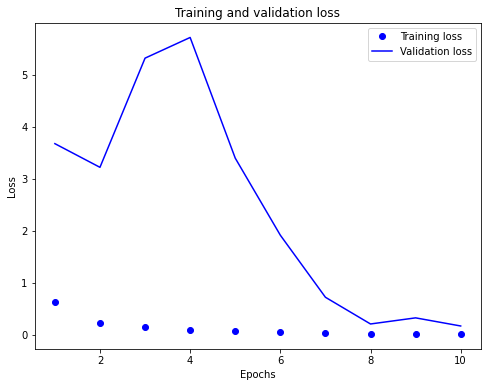

In [ ]:
# Plot the loss curves for training and validation.
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

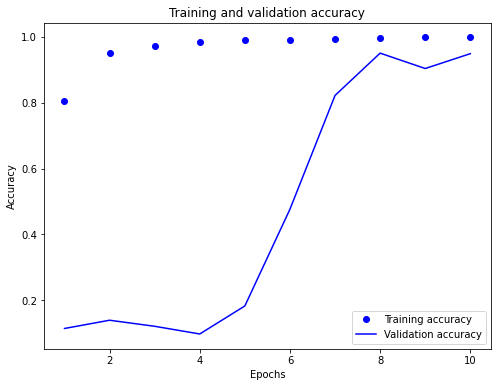

In [ ]:
# Plot the accuracy curves for training and validation.
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

We can compute the final loss and accuracy score on our valid dataset using the evaluate() function.

In [ ]:
# Compute the final loss and accuracy
final_loss, final_acc = model.evaluate(valid_dataset, verbose=0)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))

Final loss: 0.169765, final accuracy: 0.091667


In [ ]:
next(iter(test_ds))[1].numpy()[8]



2

In [ ]:
testimg = next(iter(test_ds))[0].numpy()[8]
testimg.shape
testimg = np.expand_dims(testimg, axis=0)



In [ ]:
pred = model_cnn.predict(testimg)
pred
np.argmax(pred)

3

In [ ]:
# Clean the output dir
import shutil
#shutil.rmtree('/kaggle/working/sounds-images')